<a href="https://colab.research.google.com/github/AMJAMAITHILI/ML_LAB-141/blob/main/ML_LAB2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

In [ ]:
url1 = '/content/drive/MyDrive/datasets/Santander Customer Satisfaction_train.csv'
url2 = '/content/drive/MyDrive/datasets/house_price_train.csv'
url3 = '/content/drive/MyDrive/datasets/titanic_train.csv'

# Read CSVs
df1 = pd.read_csv(url2)
df2 = pd.read_csv(url3)
df3 = pd.read_csv(url1)

In [ ]:
# Show only columns with at least one NaN
null_columns = df1.columns[df1.isnull().any()]
print("Columns with NaN values:")
print(null_columns)

Columns with NaN values:
Index(['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')


In [ ]:
fill_values = {}

# Numeric columns → mean
fill_values.update(df1.mean(numeric_only=True))#update method adds the column names (as keys) and their corresponding means to the fill_values dict

# Object/text columns → mode
fill_values.update({
    col: df1[col].mode(dropna=True)[0] #ignoring NaN values so dropna=True [0]->first of many modes
    for col in df1.select_dtypes(include='object').columns
    if not df1[col].mode(dropna=True).empty
})

df1.fillna(fill_values, inplace=True)

In [ ]:
fill_values = {}

# Numeric columns → mean
fill_values.update(df2.mean(numeric_only=True))#update method adds the column names (as keys) and their corresponding means to the fill_values dict

# Object/text columns → mode
fill_values.update({
    col: df2[col].mode(dropna=True)[0] #ignoring NaN values so dropna=True [0]->first of many modes
    for col in df2.select_dtypes(include='object').columns
    if not df2[col].mode(dropna=True).empty
})

df2.fillna(fill_values, inplace=True)

In [ ]:
# Show only columns with at least one NaN
null_columns = df1.columns[df1.isnull().any()]
print("Columns with NaN values:")
print(null_columns)

Columns with NaN values:
Index([], dtype='object')


In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(df1.drop(columns="SalePrice"),df1["SalePrice"],test_size=0.3,random_state=0)

In [ ]:
constant_features = [
    feature for feature in x_test if x_test[feature].nunique() == 1
]
print(constant_features)

['Utilities']


In [ ]:
quasi_constant_features = []

for col in x_train.columns:
    top_freq = x_train[col].value_counts(normalize=True).max()
    if top_freq > 0.99:      # appears in 99% of rows
        quasi_constant_features.append(col)

print("Quasi-constant features found:", quasi_constant_features)

Quasi-constant features found: ['Street', 'Utilities', 'Condition2', 'PoolArea', 'PoolQC', 'MiscFeature']


In [ ]:
duplicate_features = []

# Iterate over columns
for i in range(len(x_train.columns)):
    col1 = x_train.columns[i]
    for j in range(i + 1, len(x_train.columns)):
        col2 = x_train.columns[j]

        # Check if both columns are identical
        if x_train[col1].equals(x_train[col2]):
            duplicate_features.append(col2)

print("Duplicate features found:", duplicate_features)

Duplicate features found: []


Number of correlated features: 0


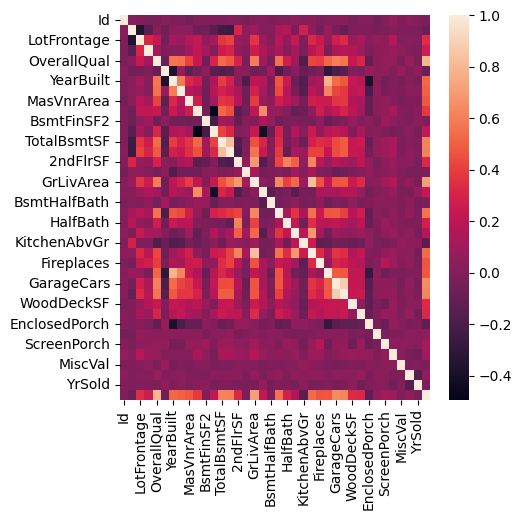

In [ ]:
# Keep only numeric columns for correlation
import matplotlib.pyplot as plt
import seaborn as sns
X = df1.select_dtypes(include='number')
corrmat = X.corr()

fig, ax = plt.subplots()
fig.set_size_inches(5,5)
sns.heatmap(corrmat)
def correlation(dataset, threshold):
    col_corr = set()
    corr_matrix = dataset.corr()

    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr
corr_features = correlation(X, 0.9)
correlated_features = set(corr_features)
print("Number of correlated features:", len(correlated_features))

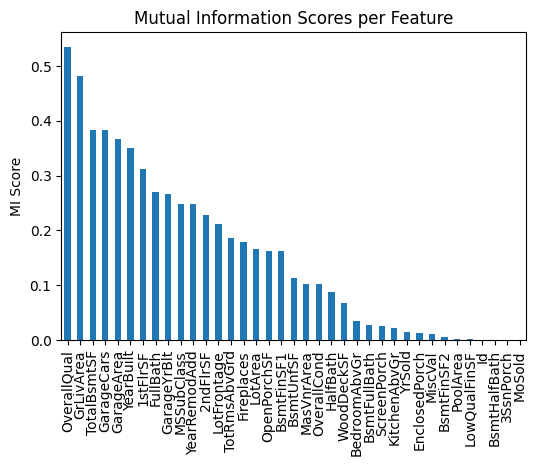

Top selected features: ['OverallQual']


In [ ]:
from sklearn.feature_selection import mutual_info_regression, SelectKBest
import pandas as pd
import matplotlib.pyplot as plt
X_num = x_train.select_dtypes(include=['number'])

mi_scores = mutual_info_regression(X_num, y_train)

# 2. Convert to a pandas Series for readability
mi_series = pd.Series(mi_scores)
mi_series.index = X_num.columns  # Label each MI score with its corresponding feature

# 3. Sort the MI scores (highest first)
mi_series = mi_series.sort_values(ascending=False)

# 4. Visualize the scores using a bar chart
plt.figure(figsize=(6,4))
mi_series.plot.bar()
plt.title("Mutual Information Scores per Feature")
plt.ylabel("MI Score")
plt.show()
from sklearn.feature_selection import SelectKBest
selector = SelectKBest(mutual_info_regression, k=1)
selector.fit(X_num, y_train)

selected_features = X_num.columns[selector.get_support()]
print(f"Top selected features:", selected_features.tolist())

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_regression


# 2. Select only numeric features after data is cleaned
x_train_numeric = x_train.select_dtypes(include=['number'])

#Perform ANOVA F-test for regression
f_scores, p_values = f_regression(x_train_numeric, y_train)

#Create Series with p-values
univariate = pd.Series(p_values, index=x_train_numeric.columns)

#Filter features with p-value < 0.05
significant_features = univariate[univariate < 0.05]
print("Significant features (p < 0.05):")
print(significant_features.index.tolist())
#Plot sorted p-values
"""univariate.sort_values(ascending=True).plot.bar(figsize=(20, 6), rot=45)
plt.ylabel("p-values")
plt.title("ANOVA F-test: Feature Significance for SalePrice")
plt.tight_layout()
plt.show()"""

"""from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import f_classif
import pandas as pd
# Separate features and target
X = df_clean.drop(columns=['Survived'])
y = df_clean['Survived']
# Encode target if categorical
if y.dtype == 'object':
    y = LabelEncoder().fit_transform(y.astype(str))
# Select only numeric features
X_num = X.select_dtypes(include=['number']).copy()
# Fill NaNs in numeric features with mean
X_num = X_num.fillna(X_num.mean())
# Perform ANOVA F-test
f_scores, p_values = f_classif(X_num, y)
# Create DataFrame with results
f_df = pd.DataFrame({
    'Feature': X_num.columns,
    'F-Score': f_scores,
    'P-Value': p_values
})
# Sort by F-Score descending
f_df = f_df.sort_values('F-Score', ascending=False)
print(f_df)
# Filter significant features (p < 0.05)
significant_features = f_df[f_df['P-Value'] < 0.05]['Feature'].tolist()
print("\nSelected features based on p-value < 0.05:", significant_features)
# Keep only significant features
X_num_filtered = X_num[significant_features]
# Optional: Add decision column
f_df['Decision'] = f_df['P-Value'].apply(
    lambda p: 'Reject Null Hypothesis' if p < 0.05 else 'Accept Null Hypothesis'
)
print("\nWith decision column:")
print(f_df[['Feature', 'F-Score', 'P-Value', 'Decision']])
o/p=>
       Feature     F-Score       P-Value
1       Pclass  115.031272  2.537047e-25
5         Fare   63.030764  6.120189e-15
4        Parch    5.963464  1.479925e-02
2          Age    4.353516  3.721708e-02
3        SibSp    1.110572  2.922439e-01
0  PassengerId    0.022285  8.813658e-01

Selected features based on p-value < 0.05: ['Pclass', 'Fare', 'Parch', 'Age']

With decision column:
       Feature     F-Score       P-Value                Decision
1       Pclass  115.031272  2.537047e-25  Reject Null Hypothesis
5         Fare   63.030764  6.120189e-15  Reject Null Hypothesis
4        Parch    5.963464  1.479925e-02  Reject Null Hypothesis
2          Age    4.353516  3.721708e-02  Reject Null Hypothesis
3        SibSp    1.110572  2.922439e-01  Accept Null Hypothesis
0  PassengerId    0.022285  8.813658e-01  Accept Null Hypothesis"""

Significant features (p < 0.05):
['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch']


In [ ]:
import pandas as pd
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder

# Encode categorical columns
df_encoded = df2.copy()
label_encoders = {}
for col in df_encoded.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
    label_encoders[col] = le

# Features (X) and target (y)
X = df_encoded.drop(columns=['Survived'])
y = df_encoded['Survived']

# Chi-square test
chi_scores, p_values = chi2(X, y)

# Put into DataFrame
chi2_df = pd.DataFrame({
    'Feature': X.columns,
    'Chi2 Score': chi_scores,
    'p-value': p_values
}).sort_values(by='Chi2 Score', ascending=False)

print(chi2_df)

        Feature   Chi2 Score       p-value
8          Fare  4518.319091  0.000000e+00
7        Ticket  2871.655466  0.000000e+00
2          Name   435.568915  9.973146e-97
9         Cabin   284.482789  7.920378e-64
3           Sex    92.702447  6.077838e-22
1        Pclass    30.873699  2.753786e-08
4           Age    24.687926  6.740514e-07
10     Embarked    10.202525  1.402485e-03
6         Parch    10.097499  1.484707e-03
0   PassengerId     3.312934  6.873667e-02
5         SibSp     2.581865  1.080942e-01


WRAPPER METHODS

In [ ]:
df1.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,Grvl,Reg,Lvl,AllPub,...,0,Gd,MnPrv,Shed,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,Grvl,Reg,Lvl,AllPub,...,0,Gd,MnPrv,Shed,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,Grvl,IR1,Lvl,AllPub,...,0,Gd,MnPrv,Shed,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,Grvl,IR1,Lvl,AllPub,...,0,Gd,MnPrv,Shed,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,Grvl,IR1,Lvl,AllPub,...,0,Gd,MnPrv,Shed,0,12,2008,WD,Normal,250000


In [ ]:
#forward selection
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.ensemble import RandomForestClassifier

# 1. Separate target
X = df1.drop(columns=["SalePrice"])
y = df1["SalePrice"]

# If SalePrice is regression target, convert to binary for roc_auc
# (Example: classify above/below median price)
y_binary = (y > y.median()).astype(int)

# 2. Encode categorical columns
X_encoded = X.copy()
for col in X_encoded.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))

# 3. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_binary, test_size=0.3, random_state=42
)

# 4. Remove correlated features
def correlation(dataset, threshold):
    col_corr = set()
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr

corr_features = correlation(X_train, 0.8)
X_train.drop(labels=corr_features, axis=1, inplace=True)
X_test.drop(labels=corr_features, axis=1, inplace=True)

# 5. Run SFS
sfs = SFS(
    RandomForestClassifier(n_jobs=4, random_state=42),
    k_features=5,
    forward=True,
    floating=False,
    verbose=2,
    scoring='roc_auc',
    cv=3
)

sfs = sfs.fit(X_train.values, y_train)

# 6. Results
print("Best ROC-AUC score: %.4f" % sfs.k_score_)
print("Best subset (indices):", sfs.k_feature_idx_)
print("Best subset (feature names):", sfs.k_feature_names_)


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   42.3s
[Parallel(n_jobs=1)]: Done  76 out of  76 | elapsed:  1.2min finished

[2025-08-13 09:12:25] Features: 1/5 -- score: 0.8907067452528422[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   36.9s
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:  1.1min finished

[2025-08-13 09:13:34] Features: 2/5 -- score: 0.9309946630963054[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   36.6s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:  1.1min finished

[2025-08-13 09:14:41] Features: 3/5 -- score: 0.9526968379106231[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   38.4s
[Parallel(n_jobs=1)]: Done  73 out of  73 | elapsed:  1.2min finished

[2025-08-13 09:15:52] Features: 4/5 -- score: 0.9604322861586855[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   39.0s


Best ROC-AUC score: 0.9654
Best subset (indices): (1, 12, 17, 37, 44)
Best subset (feature names): ('1', '12', '17', '37', '44')


[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:  1.1min finished

[2025-08-13 09:17:00] Features: 5/5 -- score: 0.9654062555641284

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# 1. Separate target and features
X = df1.drop(columns=["SalePrice"])  # features
y = df1["SalePrice"]                 # target

# Convert regression target to binary for ROC-AUC scoring
# (Above median price → 1, Below/Equal median price → 0)
y_binary = (y > y.median()).astype(int)

# 2. Encode categorical columns
X_encoded = X.copy()
for col in X_encoded.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))

# 3. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_binary, test_size=0.3, random_state=42
)

# 4. Remove correlated features
def correlation(dataset, threshold):
    col_corr = set()
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr

corr_features = correlation(X_train, 0.8)
print("Correlated features removed:", corr_features)

X_train.drop(labels=corr_features, axis=1, inplace=True)
X_test.drop(labels=corr_features, axis=1, inplace=True)

# 5. Sequential Forward Selection
sfs = SFS(
    RandomForestClassifier(n_jobs=4, random_state=42),
    k_features=5,
    forward=True,
    floating=False,
    verbose=2,
    scoring='roc_auc',   # using ROC-AUC since target is binary
    cv=3
)

# Fit with DataFrame (not .values) so column names are preserved
sfs = sfs.fit(X_train, y_train)

# 6. Results
print("Best ROC-AUC score: %.4f" % sfs.k_score_)
print("Best subset (indices):", sfs.k_feature_idx_)
print("Best subset (feature names):", sfs.k_feature_names_)

# If you still have only indices and want names:
best_feature_names = [X_train.columns[i] for i in sfs.k_feature_idx_]
print("Mapped back feature names:", best_feature_names)


Correlated features removed: {'1stFlrSF', 'Exterior2nd', 'GarageArea', 'TotRmsAbvGrd'}


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   40.6s
[Parallel(n_jobs=1)]: Done  76 out of  76 | elapsed:  1.3min finished

[2025-08-13 09:23:29] Features: 1/5 -- score: 0.8907067452528422[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   33.6s
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:  1.0min finished

[2025-08-13 09:24:31] Features: 2/5 -- score: 0.9309946630963054[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   36.6s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:  1.1min finished

[2025-08-13 09:25:37] Features: 3/5 -- score: 0.9526968379106231[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   40.8s
[Parallel(n_jobs=1)]: Done  73 out of  73 | elapsed:  1.3min finished

[2025-08-13 09:26:58] Features: 4/5 -- score: 0.9604322861586855[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   37.2s


Best ROC-AUC score: 0.9654
Best subset (indices): (1, 12, 17, 37, 44)
Best subset (feature names): ('MSSubClass', 'Neighborhood', 'OverallQual', 'TotalBsmtSF', 'GrLivArea')
Mapped back feature names: ['MSSubClass', 'Neighborhood', 'OverallQual', 'TotalBsmtSF', 'GrLivArea']


[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:  1.1min finished

[2025-08-13 09:28:06] Features: 5/5 -- score: 0.9654062555641284

In [ ]:
sbs = SFS(
    RandomForestClassifier(n_jobs=4, random_state=42),
    k_features=5,       # final number of features to keep
    forward=False,      # backward elimination
    floating=False,
    verbose=2,
    scoring='roc_auc',
    cv=3
)

sbs = sbs.fit(X_train, y_train)

# -----------------------------
# 6. Results
# -----------------------------
print("Best ROC-AUC score: %.4f" % sbs.k_score_)
print("Best subset (indices):", sbs.k_feature_idx_)
print("Best subset (feature names):", sbs.k_feature_names_)

# Map back indices to actual column names if needed
best_feature_names = [X_train.columns[i] for i in sbs.k_feature_idx_]
print("Mapped back feature names:", best_feature_names)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS

#  Exhaustive Feature Selection
lr = LogisticRegression(max_iter=500, solver='liblinear')

efs = EFS(
    estimator=lr,
    min_features=1,
    max_features=4,        # Try all combinations from 1 to 4 features
    scoring='accuracy',
    print_progress=True,   # See progress in console
    cv=5
)

efs = efs.fit(X_train, y_train)

# 6. Results
print("\nBest accuracy score: %.4f" % efs.best_score_)
print("Best subset (indices):", efs.best_idx_)
print("Best subset (feature names):", efs.best_feature_names_)

# Convert to DataFrame
efs_results = pd.DataFrame.from_dict(efs.get_metric_dict()).T
efs_results = efs_results.sort_values(by="avg_score", ascending=False)

print("\nTop feature subsets by score:")
print(efs_results.head())

# If you want just the names from indices
best_feature_names = [X_train.columns[i] for i in efs.best_idx_]
print("\nMapped best feature names:", best_feature_names)


In [ ]:
lr = LogisticRegression(max_iter=500, solver='liblinear')

# Select top 5 features (you can change n_features_to_select)
rfe = RFE(estimator=lr, n_features_to_select=5)
rfe = rfe.fit(X_train, y_train)

# 6. Results

print("Selected Features (Boolean mask):", rfe.support_)
print("Feature Ranking:", rfe.ranking_)

# Get feature names
selected_features = X_train.columns[rfe.support_]
print("\nSelected Feature Names:", list(selected_features))

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from sklearn.feature_selection import RFE

# Loading dataset
data = df1.copy()
# Using only numerical features
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
num_data = data.select_dtypes(include=numerics).dropna(axis=1)

X = num_data.drop("SalePrice", axis=1)
y = num_data["SalePrice"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)



In [ ]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.ensemble import RandomForestRegressor

sfs = SFS(RandomForestRegressor(),
          k_features=5,
          forward=True,
          floating=False,
          scoring='r2',
          cv=5)
sfs.fit(X_train, y_train)
print("Forward Selection")
print("Selected feature indices:", sfs.k_feature_idx_)
print("Selected feature names:", sfs.k_feature_names_)
print("Best R² score: %.4f" % sfs.k_score_)


Forward Selection
Selected feature indices: (1, 3, 14, 22, 23)
Selected feature names: ('MSSubClass', 'OverallQual', 'GrLivArea', 'Fireplaces', 'GarageCars')
Best R² score: 0.7756


In [ ]:
sbs = SFS(RandomForestRegressor(),
          k_features=5,
          forward=False,
          floating=False,
          scoring='r2',
          cv=5)

sfs.fit(X_train, y_train)

print("Backward Selection")
print("Selected feature indices:", sfs.k_feature_idx_)
print("Selected feature names:", sfs.k_feature_names_)
print("Best R² score: %.4f" % sfs.k_score_)


Backward Selection
Selected feature indices: (1, 3, 14, 22, 23)
Selected feature names: ('MSSubClass', 'OverallQual', 'GrLivArea', 'Fireplaces', 'GarageCars')
Best R² score: 0.7824


In [ ]:
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS

efs = EFS(RandomForestRegressor(),
          min_features=3,
          max_features=5,
          scoring='r2',
          cv=3,
          print_progress=True)
sfs.fit(X_train, y_train)

efs = efs.fit(X_train, y_train)

efs_results = efs.get_metric_dict()

best = max(efs_results.items(), key=lambda x: x[1]['avg_score'])

best_features_idx = best[0]
best_score = best[1]['avg_score']
best_feature_names = X_train.columns[list(best_features_idx)]

print("\n🔹 Exhaustive Feature Selection")
print("Best subset indices:", best_features_idx)
print("Best feature names:", best_feature_names.tolist())
print("Best average R² score: %.4f" % best_score)


In [ ]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

rfe = RFE(estimator=RandomForestRegressor(), n_features_to_select=5)
rfe.fit(X_train, y_train)

selected_features = X_train.columns[rfe.support_].tolist()
print("\n RFE Selected Features:")
print("Selected features:", selected_features)

X_test_rfe = X_test[selected_features]
y_pred = rfe.estimator_.predict(X_test_rfe)
score = r2_score(y_test, y_pred)
print("R² score on test data (RFE features): %.4f" % score)


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA (keep 2 components for visualization)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print("Explained Variance Ratio:", pca.explained_variance_ratio_)

# Plot PCA
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap="viridis", alpha=0.5)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA on House Prices Data")
plt.show()


In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Convert SalePrice into 3 categories
y_cat = pd.qcut(y, q=3, labels=["Low", "Medium", "High"])

# Apply LDA
lda = LDA(n_components=2)
X_lda = lda.fit_transform(X_scaled, y_cat)

print("Explained Variance Ratio (LDA):", lda.explained_variance_ratio_)

# Plot LDA
plt.scatter(X_lda[:, 0], X_lda[:, 1], c=y_cat.cat.codes, cmap="coolwarm", alpha=0.6)
plt.xlabel("LD1")
plt.ylabel("LD2")
plt.title("LDA on House Prices Data")
plt.show()
